Step 50:
Style loss: 84103528.0000
Content loss: 394.9390

Step 100:
Style loss: 20417652.0000
Content loss: 415.6191

Step 150:
Style loss: 8529819.0000
Content loss: 424.9862

Step 200:
Style loss: 4405220.0000
Content loss: 431.0629

Step 250:
Style loss: 2612777.2500
Content loss: 435.7169

Step 300:
Style loss: 1766509.2500
Content loss: 439.5878



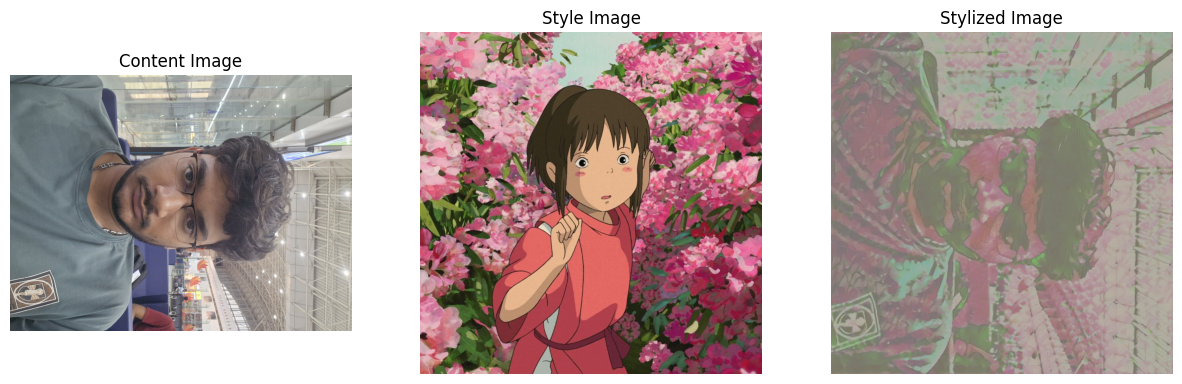

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# ------------------------------
# 1. Setup and Image Loading
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 256

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def image_loader(image_path):
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0)  # Add batch dimension
    return image.to(device, torch.float)

# ------------------------------
# 2. Loss Functions
# ------------------------------
def gram_matrix(input):
    batch, channels, height, width = input.size()
    features = input.view(batch * channels, height * width)
    G = torch.mm(features, features.t())
    return G.div(height * width)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

# ------------------------------
# 3. Model Setup
# ------------------------------
cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

content_layers = ['conv_4']  # Deeper layer for content
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, style_img, content_img):
    content_losses = []
    style_losses = []

    # Build model with normalization and loss layers
    normalization = nn.Sequential(
        nn.InstanceNorm2d(3),
        transforms.Normalize(cnn_normalization_mean, cnn_normalization_std)
    ).to(device)

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # Add content loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # Add style loss
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

# ------------------------------
# 4. Image Display Functions
# ------------------------------
def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def tensor_to_image(tensor):
    tensor = tensor.squeeze(0).cpu().detach()
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return tensor.clamp(0, 1).permute(1, 2, 0).numpy()

# ------------------------------
# 5. Main Style Transfer Function
# ------------------------------
def run_style_transfer(content_img_path, style_img_path, num_steps=300,
                      content_weight=1, style_weight=1e5):
    # Load images
    content_img = image_loader(content_img_path)
    style_img = image_loader(style_img_path)

    assert content_img.size() == style_img.size()

    input_img = content_img.clone()
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, style_img, content_img)

    # Input needs gradient for optimization
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = optim.LBFGS([input_img], lr=1, max_iter=20)

    run = [0]
    while run[0] <= num_steps:
        def closure():
            # Clamp to maintain pixel values
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            content_score = 0
            style_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]}:")
                print(f"Style loss: {style_score.item():.4f}")
                print(f"Content loss: {content_score.item():.4f}")
                print()

            return style_score + content_score

        optimizer.step(closure)

    # Final clamp
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

# ------------------------------
# 6. Run and Display Results
# ------------------------------
def display_results(content_path, style_path):
    plt.figure(figsize=(15,5))

    # Content image
    plt.subplot(1,3,1)
    content_img = Image.open(content_path)
    plt.imshow(content_img)
    plt.title("Content Image")
    plt.axis('off')

    # Style image
    plt.subplot(1,3,2)
    style_img = Image.open(style_path)
    plt.imshow(style_img)
    plt.title("Style Image")
    plt.axis('off')

    # Stylized image
    plt.subplot(1,3,3)
    output = run_style_transfer(content_path, style_path)
    output_img = tensor_to_image(output)
    plt.imshow(output_img)
    plt.title("Stylized Image")
    plt.axis('off')

    plt.show()

# Example usage:
content_path = "/content/20250502_172554.jpg"  # Replace with your content image path
style_path = "/content/1d872204c01eb784e0c51376e72effb6.jpg"      # Replace with your style image path
display_results(content_path, style_path)


Step 0: Style 1303416064.00 | Content 0.00
Step 50: Style 87880616.00 | Content 19.41
Step 100: Style 42971512.00 | Content 21.69
Step 150: Style 29611200.00 | Content 22.67
Step 200: Style 23270042.00 | Content 23.23
Step 250: Style 19504514.00 | Content 23.62
Step 300: Style 16985188.00 | Content 23.91
Step 350: Style 15171673.00 | Content 24.14
Step 400: Style 13795326.00 | Content 24.33
Step 450: Style 12709157.00 | Content 24.50
Step 500: Style 11834002.00 | Content 24.64
Step 550: Style 11110882.00 | Content 24.76


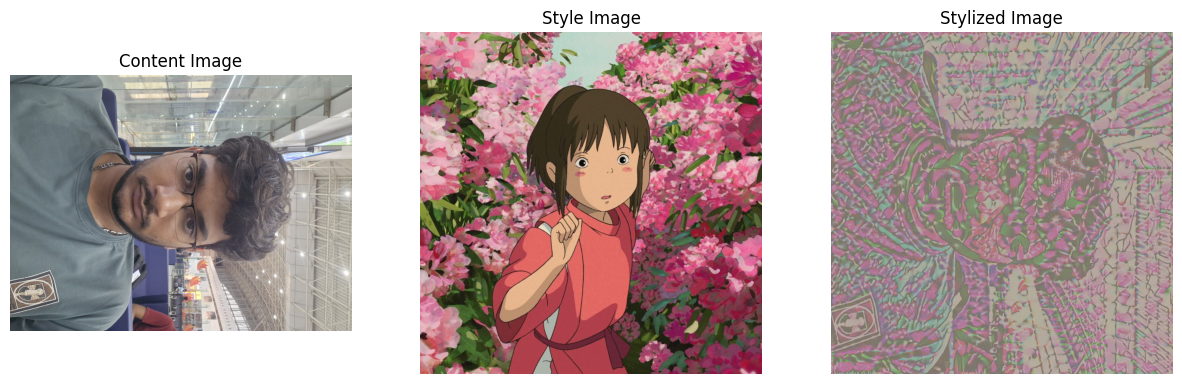

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# ------------------------------
# 1. Device and Image Setup
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 256

# Preprocessing for VGG
preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float)

# ------------------------------
# 2. Loss Functions
# ------------------------------
def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(h * w)  # Normalize by spatial size

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

# Total Variation Loss for smoothness
def total_variation_loss(img, weight=1e-4):
    b, c, h, w = img.size()
    tv_loss = torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
              torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return weight * tv_loss

# ------------------------------
# 3. Build Style Transfer Model
# ------------------------------
cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

# Improved layer selection for better quality
content_layers = ['conv_4']  # deeper content
style_layers = ['conv_1', 'conv_3', 'conv_5']  # fewer but meaningful style layers

def get_style_model_and_losses(cnn, style_img, content_img):
    model = nn.Sequential()
    content_losses = []
    style_losses = []

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    model = model[:i+1]

    return model, style_losses, content_losses

# ------------------------------
# 4. Style Transfer Function
# ------------------------------
def run_style_transfer(content_path, style_path,
                       num_steps=600,  # increased for better quality
                       style_weight=2e6,  # stronger style
                       content_weight=1,
                       tv_weight=1e-4):  # smoother result
    content_img = load_image(content_path)
    style_img = load_image(style_path)

    assert content_img.size() == style_img.size(), "Images must be same size"

    input_img = content_img.clone().requires_grad_(True)

    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, style_img, content_img)

    optimizer = optim.Adam([input_img], lr=0.02)

    for step in range(num_steps):
        optimizer.zero_grad()
        model(input_img)

        style_score = sum(sl.loss for sl in style_losses) * style_weight
        content_score = sum(cl.loss for cl in content_losses) * content_weight
        tv_score = total_variation_loss(input_img, tv_weight)

        loss = style_score + content_score + tv_score
        loss.backward()

        optimizer.step()
        with torch.no_grad():
            input_img.clamp_(0, 1)

        if step % 50 == 0:
            print(f"Step {step}: Style {style_score.item():.2f} | Content {content_score.item():.2f}")

    return input_img

# ------------------------------
# 5. Display Results
# ------------------------------
def tensor_to_image(tensor):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    return image.clamp(0,1).permute(1,2,0).numpy()

def display_results(content_path, style_path):
    plt.figure(figsize=(15,5))

    # Content
    plt.subplot(1,3,1)
    plt.imshow(Image.open(content_path))
    plt.title("Content Image")
    plt.axis('off')

    # Style
    plt.subplot(1,3,2)
    plt.imshow(Image.open(style_path))
    plt.title("Style Image")
    plt.axis('off')

    # Stylized
    output = run_style_transfer(content_path, style_path)
    plt.subplot(1,3,3)
    plt.imshow(tensor_to_image(output))
    plt.title("Stylized Image")
    plt.axis('off')

    plt.show()

# Example usage
content_path = "/content/20250502_172554.jpg"
style_path = "/content/1d872204c01eb784e0c51376e72effb6.jpg"
display_results(content_path, style_path)
